# IMPORT

In [1]:
import pandas as pd
import numpy as np
import re
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from deep_translator import GoogleTranslator
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from textblob import TextBlob

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, SimpleRNN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from joblib import dump, load

# DATA CLEANING AND PREPROCESSING

In [2]:
# Initialize the translator
translator = GoogleTranslator(source='auto', target='en')

def translate_text(text):
    try:
        return translator.translate(text)
    except Exception as e:
        return text  # Return the original text if translation fails

## TRANSLATING RUSSIAN INTO ENGLISH

In [3]:
if os.path.exists('dataset/translated_dota2_chat.csv'):
    # Load the dataset
    df = pd.read_csv('dataset/translated_dota2_chat.csv')

    # Remove duplicate rows
    df.drop_duplicates(inplace=True)
    print(df.head(10))
    
else:
    df = pd.read_csv('dataset/dota2_chat_messages.csv', nrows=20000)
    df['text'] = df['text'].fillna('')

    print('Mean length of text', df['text'].apply(lambda x: len(x)).mean())
    
    # Translate the text into english
    df['translated_text'] = df['text'].apply(translate_text)

    df.to_csv('dataset/translated_dota2_chat.csv', index=False)
    
    # Display the first few rows after translation
    print(df[['text', 'translated_text']].head())

   match        time  slot                    text         translated_text
0      0  1005.12122     9               ладно гг                    ok gg
1      0  1005.85442     9                     изи                   trail
2      0  1008.65372     9                      од                    from
3      0  1010.51992     9                  ебаный                 fucking
4      0  1013.91912     9          мусор на войде    garbage in the waste
5      0  1800.31402     9                  мусор                  garbage
6      0  1801.71882     9                на войде              on entered
7      0  1802.98982     9                  репорт                  report
8      0  1808.40822     9                    100%                    100%
9      1  -131.14018     0  twitch.tv/rage_channel  twitch.tv/rage_channel


## CLEANING

In [4]:
# Function to clean text
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = word_tokenize(text)  # Tokenize
    text = [word for word in text if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(text)

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_nan(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() != 'nan']
    return ' '.join(filtered_words)


In [5]:
# Clean the text
df['cleaned_text'] = df['translated_text'].apply(clean_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_nan)
df['cleaned_text'].replace('', float('NaN'), inplace=True)
df.dropna(subset=['cleaned_text'], inplace=True)

# Display the first few rows after cleaning
print(df[['translated_text','cleaned_text']].head(10))

           translated_text         cleaned_text
0                    ok gg                ok gg
1                    trail                trail
3                  fucking              fucking
4     garbage in the waste        garbage waste
5                  garbage              garbage
6               on entered              entered
7                   report               report
8                     100%                  100
9   twitch.tv/rage_channel  twitchtvragechannel
11       2 dashas in a row         2 dashas row


## LABELING DATA

In [6]:
def label_toxicity_gaming(text):
    toxic_keywords = [
         # General Insults
        'noob', 'idiot', 'moron', 'loser', 'scrub', 'trash', 'garbage', 'pathetic', 'retard', 'stupid',
        'dumb', 'fool', 'clown', 'imbecile', 'simpleton', 'pussy', 'retarded', 'dog', 'wtf', 'died',
        # Profanity
        'fuck', 'fucking', 'shit', 'damn', 'hell', 'bitch', 'bastard', 'ass', 'asshole', 'dick', 'prick',
        'piss', 'piss off', 'cunt',
        # Sexist and Racist Slurs
        'whore', 'slut', 'nigger', 'nigga', 'faggot', 'fag', 'dyke', 'chink', 'spic', 'kike', 'wop', 'gook', 'mother died',
        # Aggressive Phrases
        'kill yourself', 'go die', 'shut up', 'fuck off', 'get lost', 'piece of shit', 'worthless', 'waste of space', 
        'die in a fire', 'go to hell',
        # Gameplay-Related Insults
        'feeder', 'thrower', 'troll', 'griefer', 'report', 'afk', 'uninstall', 'l2p', 'scrub', 'camp', 'camping', 
        'cheat', 'hacker', 'die',
        # Other Abusive Terms
        'cancer', 'aids', 'kys', 'n00b', 'pleb', 'shithead', 'dipshit', 'douchebag', 'twat', 'wanker', 'jackass', 'stfu', 'nice death', 'useless'
    ]
    text = str(text).lower()  # Convert text to lowercase
    if any(keyword in text for keyword in toxic_keywords):
        return 1  # Toxic
    return 0  # Not toxic

In [7]:
# Apply the gaming-specific labeling function
df['label'] = df['translated_text'].apply(label_toxicity_gaming)

df.to_csv('dataset/cleaned_dota2_chat.csv', index=False)

print(df.head(15))

    match        time  slot                        text  \
0       0  1005.12122     9                   ладно гг    
1       0  1005.85442     9                         изи   
3       0  1010.51992     9                      ебаный   
4       0  1013.91912     9              мусор на войде   
5       0  1800.31402     9                      мусор    
6       0  1801.71882     9                    на войде   
7       0  1802.98982     9                      репорт   
8       0  1808.40822     9                        100%   
9       1  -131.14018     0      twitch.tv/rage_channel   
11      1   244.47367     7              2 даша подряд    
12      1   249.93900     7                       баша    
13      1   255.00443     4                   где даша?   
14      1   261.20293     4                  даша домой   
15      1   597.98733     4  долбоеб сука на дизрапторе   
16      1   689.59830     6     даун с 1 тычки забашил    

                translated_text            cleaned_text

## EDA

In [8]:
# Basic statistics
print(df['label'].value_counts())

label
0    14840
1     2888
Name: count, dtype: int64


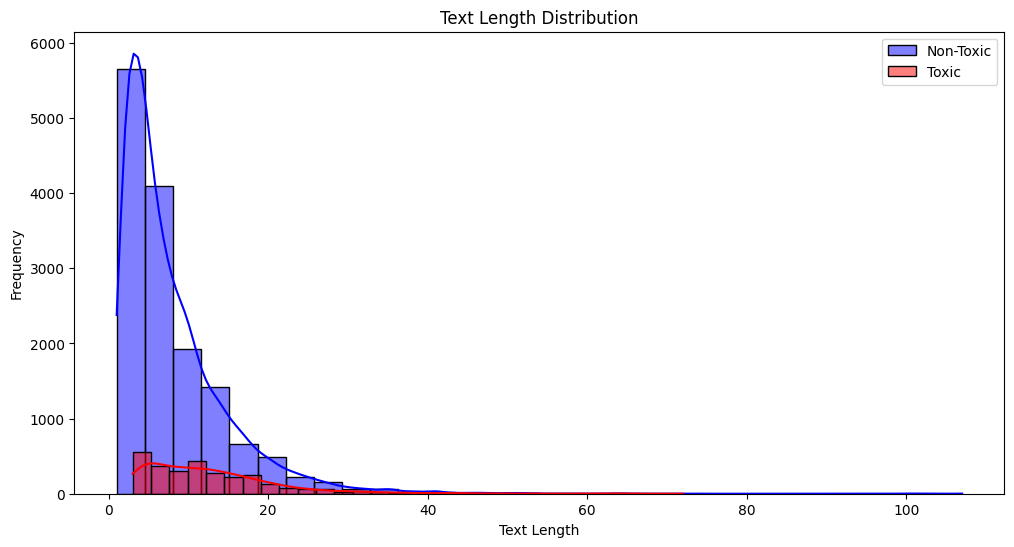

In [9]:
# Adding a column for text length
df['text_length'] = df['cleaned_text'].apply(len)

# Plotting text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df[df['label'] == 0]['text_length'], color='blue', label='Non-Toxic', kde=True, bins=30)
sns.histplot(df[df['label'] == 1]['text_length'], color='red', label='Toxic', kde=True, bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [10]:
# Function to get the most common words
def get_common_words(texts, n=20):
    words = ' '.join(texts).split()
    counter = Counter(words)
    return counter.most_common(n)

# Most common words in non-toxic messages
non_toxic_common_words = get_common_words(df[df['label'] == 0]['cleaned_text'])
print("Most common words in non-toxic messages:", non_toxic_common_words)

# Most common words in toxic messages
toxic_common_words = get_common_words(df[df['label'] == 1]['cleaned_text'])
print("Most common words in toxic messages:", toxic_common_words)

Most common words in non-toxic messages: [('gg', 1205), ('lol', 393), ('xd', 294), ('u', 271), ('wp', 252), ('game', 246), ('mid', 201), ('go', 196), ('end', 185), ('dont', 179), ('haha', 164), ('team', 157), ('im', 152), ('hahaha', 147), ('like', 146), ('nice', 132), ('yes', 130), ('guys', 124), ('ggwp', 124), ('ez', 122)]
Most common words in toxic messages: [('fuck', 499), ('report', 389), ('fucking', 284), ('fucked', 154), ('bitch', 151), ('shit', 124), ('noob', 95), ('wtf', 90), ('afk', 84), ('dont', 78), ('stupid', 65), ('youre', 64), ('go', 58), ('mother', 57), ('give', 52), ('team', 51), ('idiot', 48), ('dog', 47), ('u', 47), ('die', 47)]


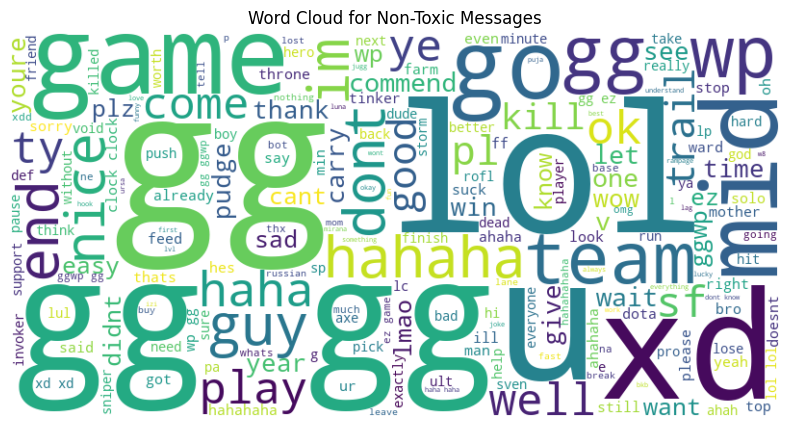

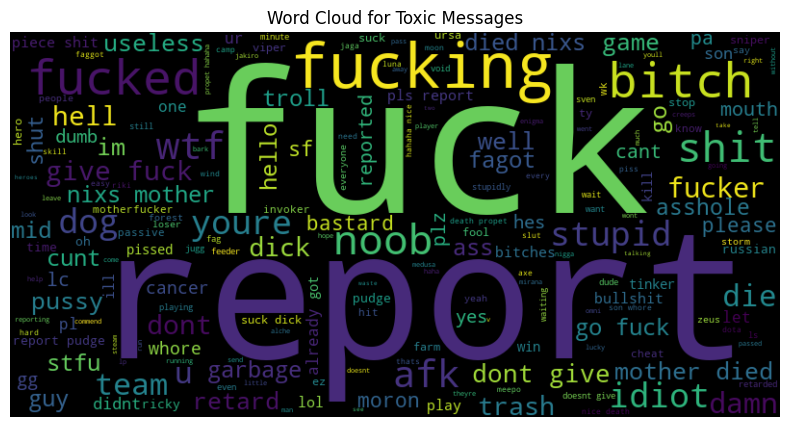

In [11]:
# Generating word clouds
non_toxic_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
toxic_text = ' '.join(df[df['label'] == 1]['cleaned_text'])

# Word Cloud for non-toxic messages
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_text)
plt.figure(figsize=(10, 5))
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Messages')
plt.show()

# Word Cloud for toxic messages
toxic_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(toxic_text)
plt.figure(figsize=(10, 5))
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Messages')
plt.show()

In [12]:
# Function to get n-grams
def get_ngrams(texts, n=2, top_n=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Bigrams in non-toxic messages
non_toxic_bigrams = get_ngrams(df[df['label'] == 0]['cleaned_text'], n=2)
print("Most common bigrams in non-toxic messages:", non_toxic_bigrams)

# Bigrams in toxic messages
toxic_bigrams = get_ngrams(df[df['label'] == 1]['cleaned_text'], n=2)
print("Most common bigrams in toxic messages:", toxic_bigrams)

# Trigrams in non-toxic messages
non_toxic_trigrams = get_ngrams(df[df['label'] == 0]['cleaned_text'], n=3)
print("Most common trigrams in non-toxic messages:", non_toxic_trigrams)

# Trigrams in toxic messages
toxic_trigrams = get_ngrams(df[df['label'] == 1]['translated_text'], n=3)
print("Most common trigrams in toxic messages:", toxic_trigrams)

Most common bigrams in non-toxic messages: [('gg wp', 133), ('clock clock', 42), ('gg ez', 24), ('ez game', 22), ('dont know', 21), ('go end', 19), ('let go', 18), ('gl hf', 17), ('good luck', 16), ('yes yes', 14), ('new year', 14), ('ez mid', 14), ('end pls', 12), ('ha ha', 12), ('know wey', 12), ('happy new', 11), ('long time', 11), ('uganda neeeds', 11), ('neeeds ur', 11), ('ur help', 11)]
Most common bigrams in toxic messages: [('give fuck', 40), ('dont give', 36), ('mother died', 31), ('nixs mother', 29), ('go fuck', 26), ('piece shit', 14), ('youre fucking', 13), ('youre fucked', 11), ('suck dick', 10), ('report sf', 9), ('report pudge', 9), ('report mid', 9), ('pls report', 9), ('well fuck', 8), ('report lc', 7), ('give shit', 7), ('doesnt give', 7), ('fucking idiot', 7), ('get fucked', 7), ('report team', 7)]
Most common trigrams in non-toxic messages: [('clock clock clock', 35), ('happy new year', 11), ('uganda neeeds ur', 11), ('neeeds ur help', 11), ('ha ha ha', 6), ('dont k

# MODELS TRAINING

In [13]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Extract the text and labels
train_texts = train_data['cleaned_text']
train_labels = train_data['label']
test_texts = test_data['cleaned_text']
test_labels = test_data['label']

In [14]:
def sentiment_analysis(text):
    analysis = TextBlob(text)
    return 1 if analysis.sentiment.polarity < 0 else 0

# Apply sentiment analysis
test_sentiment_labels = test_texts.apply(sentiment_analysis)

# Evaluate sentiment analysis
print("Sentiment Analysis Metrics:")
print(classification_report(test_labels, test_sentiment_labels))

Sentiment Analysis Metrics:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      4440
           1       0.59      0.48      0.53       879

    accuracy                           0.86      5319
   macro avg       0.74      0.71      0.72      5319
weighted avg       0.85      0.86      0.85      5319



In [22]:
# Ensure train_texts and test_texts are lists of strings
train_texts = list(train_texts) if isinstance(train_texts, (pd.Series, np.ndarray)) else train_texts
test_texts = list(test_texts) if isinstance(test_texts, (pd.Series, np.ndarray)) else test_texts

# Vectorize text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
train_tfidf_vectors = tfidf_vectorizer.fit_transform(train_texts)
test_tfidf_vectors = tfidf_vectorizer.transform(test_texts)

# Initialize traditional ML models with additional parameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced'),
    "Support Vector Machine": SVC(C=1.0, kernel='linear', probability=True, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=1),
    "Neural Network": MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto')
}

# Training and evaluating the models with cross-validation
results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, train_tfidf_vectors, train_labels, cv=5, scoring='accuracy')
    model.fit(train_tfidf_vectors, train_labels)
    predictions = model.predict(test_tfidf_vectors)
    metrics = classification_report(test_labels, predictions, output_dict=True)
    results[model_name] = metrics
    print(f"{model_name} Metrics:")
    print(classification_report(test_labels, predictions))
    print(f"{model_name} Cross-Validation Scores: {scores}")
    print(f"{model_name} Average Cross-Validation Score: {scores.mean()}")

    # Save the model
    dump(model, f'results/model_{model_name}.joblib')

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4440
           1       0.99      0.92      0.96       879

    accuracy                           0.99      5319
   macro avg       0.99      0.96      0.97      5319
weighted avg       0.99      0.99      0.99      5319

Logistic Regression Cross-Validation Scores: [0.98509267 0.98307816 0.98267526 0.98791297 0.98508666]
Logistic Regression Average Cross-Validation Score: 0.9847691447750689
Support Vector Machine Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4440
           1       0.99      0.96      0.97       879

    accuracy                           0.99      5319
   macro avg       0.99      0.98      0.98      5319
weighted avg       0.99      0.99      0.99      5319

Support Vector Machine Cross-Validation Scores: [0.98992748 0.99113618 0.98952458 0.99274778 0.99072954]
Support

In [16]:
# Define functions for each of the new models

# Optimized model architectures
def create_cnn_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(64, 5, activation='relu'),
        MaxPooling1D(5),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output layer uses float32
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_rnn_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(32, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# Tokenization and preparation
vocab_size = 5000  # example vocab size
embedding_dim = 100  # example embedding dimension
max_length = 100  # example max length of the sequences

# Create instances of each model
cnn_model = create_cnn_model(vocab_size, embedding_dim, max_length)
rnn_model = create_rnn_model(vocab_size, embedding_dim, max_length)
lstm_model = create_lstm_model(vocab_size, embedding_dim, max_length)

# Implement early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train and evaluate the models
cnn_model.fit(train_tfidf_vectors, train_labels, epochs=5, validation_data=(test_tfidf_vectors, test_labels), batch_size=64, callbacks=[early_stopping])
rnn_model.fit(train_tfidf_vectors, train_labels, epochs=5, validation_data=(test_tfidf_vectors, test_labels), batch_size=64, callbacks=[early_stopping])
lstm_model.fit(train_tfidf_vectors, train_labels, epochs=5, validation_data=(test_tfidf_vectors, test_labels), batch_size=64, callbacks=[early_stopping])

# Save the models
cnn_model.save('results/cnn_model.h5')
rnn_model.save('results/rnn_model.h5')
lstm_model.save('results/lstm_model.h5')

# Evaluate the models and print the results
cnn_results = cnn_model.evaluate(test_tfidf_vectors, test_labels)
rnn_results = rnn_model.evaluate(test_tfidf_vectors, test_labels)
lstm_results = lstm_model.evaluate(test_tfidf_vectors, test_labels)

print("CNN Results:", cnn_results)
print("RNN Results:", rnn_results)
print("LSTM Results:", lstm_results)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 176s 896ms/step - accuracy: 0.8272 - loss: 0.4799 - val_accuracy: 0.8347 - val_loss: 0.4610
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 166s 856ms/step - accuracy: 0.8327 - loss: 0.4404 - val_accuracy: 0.8347 - val_loss: 0.4349
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 167s 861ms/step - accuracy: 0.8387 - loss: 0.4291 - val_accuracy: 0.8347 - val_loss: 0.4357
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 166s 857ms/step - accuracy: 0.8312 - loss: 0.4391 - val_accuracy: 0.8347 - val_loss: 0.4350
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 166s 856ms/step - accuracy: 0.8408 - loss: 0.4256 - val_accuracy: 0.8347 - val_loss: 0.4350
Epoch 1/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 842s 4s/step - accuracy: 0.8196 - loss: 0.4784 - val_accuracy: 0.8347 - val_loss: 0.4496
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 832s 4s/step - accuracy: 0.8348 - loss: 0.4627 - val_accuracy: 0.8347 - val_loss: 0.4485
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 842s 4s/step - accuracy: 0.8358 - loss: 0.4617 - v

167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8363 - loss: 0.4341
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - accuracy: 0.8363 - loss: 0.4462
167/167 ━━━━━━━━━━━━━━━━━━━━ 89s 532ms/step - accuracy: 0.8363 - loss: 0.4459
CNN Results: [0.4350004494190216, 0.8347433805465698]
RNN Results: [0.44874459505081177, 0.8347433805465698]
LSTM Results: [0.44844716787338257, 0.8347433805465698]


## SUMMARY REPORT

In [23]:
# Load the saved ML models
logistic_regression_model = load('model_Logistic Regression.joblib')
svm_model = load('model_Support Vector Machine.joblib')
random_forest_model = load('model_Random Forest.joblib')
gradient_boosting_model = load('model_Gradient Boosting.joblib')
mlp_model = load('model_Neural Network.joblib')

# Load the saved DL models
loaded_cnn_model = load_model('cnn_model.h5')
loaded_rnn_model = load_model('rnn_model.h5')
loaded_lstm_model = load_model('lstm_model.h5')

# Evaluate the loaded ML models
logistic_regression_predictions = logistic_regression_model.predict(test_tfidf_vectors)
svm_predictions = svm_model.predict(test_tfidf_vectors)
random_forest_predictions = random_forest_model.predict(test_tfidf_vectors)
gradient_boosting_predictions = gradient_boosting_model.predict(test_tfidf_vectors)
mlp_predictions = mlp_model.predict(test_tfidf_vectors)

# Convert predictions to binary labels for ML models
logistic_regression_pred_labels = logistic_regression_predictions
svm_pred_labels = svm_predictions
random_forest_pred_labels = random_forest_predictions
gradient_boosting_pred_labels = gradient_boosting_predictions
mlp_pred_labels = mlp_predictions

# Evaluate the loaded DL models
loaded_cnn_results = loaded_cnn_model.evaluate(test_tfidf_vectors, test_labels)
loaded_rnn_results = loaded_rnn_model.evaluate(test_tfidf_vectors, test_labels)
loaded_lstm_results = loaded_lstm_model.evaluate(test_tfidf_vectors, test_labels)

# Predict using the loaded DL models
cnn_predictions = loaded_cnn_model.predict(test_tfidf_vectors)
rnn_predictions = loaded_rnn_model.predict(test_tfidf_vectors)
lstm_predictions = loaded_lstm_model.predict(test_tfidf_vectors)

# Convert predictions to binary labels for DL models
cnn_pred_labels = (cnn_predictions > 0.5).astype(int).flatten()
rnn_pred_labels = (rnn_predictions > 0.5).astype(int).flatten()
lstm_pred_labels = (lstm_predictions > 0.5).astype(int).flatten()

# Print classification reports
print("Logistic Regression Classification Report:")
print(classification_report(test_labels, logistic_regression_pred_labels))

print("SVM Classification Report:")
print(classification_report(test_labels, svm_pred_labels))

print("Random Forest Classification Report:")
print(classification_report(test_labels, random_forest_pred_labels))

print("Gradient Boosting Classification Report:")
print(classification_report(test_labels, gradient_boosting_pred_labels))

print("MLP Classification Report:")
print(classification_report(test_labels, mlp_pred_labels))

print("CNN Classification Report:")
print(classification_report(test_labels, cnn_pred_labels))

print("RNN Classification Report:")
print(classification_report(test_labels, rnn_pred_labels))

print("LSTM Classification Report:")
print(classification_report(test_labels, lstm_pred_labels))

# Print accuracy scores for comparison
print(f"Logistic Regression Accuracy: {accuracy_score(test_labels, logistic_regression_pred_labels)}")
print(f"SVM Accuracy: {accuracy_score(test_labels, svm_pred_labels)}")
print(f"Random Forest Accuracy: {accuracy_score(test_labels, random_forest_pred_labels)}")
print(f"Gradient Boosting Accuracy: {accuracy_score(test_labels, gradient_boosting_pred_labels)}")
print(f"MLP Accuracy: {accuracy_score(test_labels, mlp_pred_labels)}")
print(f"CNN Accuracy: {accuracy_score(test_labels, cnn_pred_labels)}")
print(f"RNN Accuracy: {accuracy_score(test_labels, rnn_pred_labels)}")
print(f"LSTM Accuracy: {accuracy_score(test_labels, lstm_pred_labels)}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8363 - loss: 0.4341
167/167 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - accuracy: 0.8363 - loss: 0.4462
167/167 ━━━━━━━━━━━━━━━━━━━━ 119s 703ms/step - accuracy: 0.8363 - loss: 0.4459
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 482ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 116s 692ms/step
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4440
           1       0.99      0.92      0.96       879

    accuracy                           0.99      5319
   macro avg       0.99      0.96      0.97      5319
weighted avg       0.99      0.99      0.99      5319

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4440
           1       0.99      0.96      0.97       879

    accuracy                           0.99      5319
   macro avg      

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo